DBSCAN clustering

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import warnings
import itertools
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore")

# folder za cuvanje slika
save_folder = "dbscan images"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
# ucitavanje
fn = "20150101_20251231_Magurele_Inoe20DOPUNJEN.ods"
df = pd.read_excel(fn, engine="odf")

# 4 kolone koje koristim za klasterizaciju
cols = [
    "Extinction_Angstrom_Exponent_440-870nm-Total",
    "Single_Scattering_Albedo[440nm]",
    "Refractive_Index-Real_Part[440nm]",
    "Color Ratio[440-870]"
]

missing = [c for c in cols if c not in df.columns]
if missing:
    raise KeyError(f"nedostaju kolone u fajlu: {missing}")

data = df[cols].copy()
print("dimenzije:", data.shape)
display(data.head())

# provera da li imam nan
if data.isna().any().any():
    print("ima nan vrednosti")
else:
    print("nema nan vrednosti")

data_clean = data.copy()
print("dimenzije nakon provere:", data_clean.shape)

# skaliranje podataka
scaler = StandardScaler()
X = scaler.fit_transform(data_clean.values)

# DBSCAN 
# biram eps i min_samples 
dbscan = DBSCAN(eps=1, min_samples=3)  
labels = dbscan.fit_predict(X)

data_clean = data_clean.reset_index(drop=True)
data_clean['cluster'] = labels  # -1 je noise/ outlier

print("\nbroj clanova po klasteru (-1 = noise):")
print(data_clean['cluster'].value_counts().sort_index())



# statistika po klasterima, reorganizovano po klasterima
cluster_stats = {}

for cl in sorted(data_clean["cluster"].unique()):
    rows = []
    for c in cols:
        vals = data_clean.loc[data_clean["cluster"] == cl, c]
        mean = vals.mean()
        std = vals.std()
        median = vals.median()
        minv = vals.min()
        maxv = vals.max()
        r = maxv - minv
        mode_vals = vals.mode()
        mode_val = mode_vals.iloc[0] if not mode_vals.empty else np.nan

        rows.append({
            "Parametar": c,
            "Median": round(median, 3),
            "Mean ± Std": f"{mean:.2f} ± {std:.2f}",
            "Mode (Value of maximum frequency)": round(mode_val, 3),
            "Range": f"{minv:.2f} – {maxv:.2f}"
        })
    cluster_stats[cl] = pd.DataFrame(rows)

# prikaz za svaki klaster
for cl, tbl in cluster_stats.items():
    print(f"\n=== statistika za klaster {cl} ===")
    display(tbl)
    

# PCA vizualizacija 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
unique_labels = sorted(set(labels))
colors = plt.cm.tab10(np.linspace(0,1,len(unique_labels)))

for lab, col in zip(unique_labels, colors):
    mask = labels == lab
    if lab == -1:
        plt.scatter(X_pca[mask,0], X_pca[mask,1], c=[col], marker='x', label='Noise', alpha=0.7, s=5)
    else:
        plt.scatter(X_pca[mask,0], X_pca[mask,1], c=[col], label=f'Cluster {lab}', alpha=0.6, s=5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('DBSCAN — PCA projection')
plt.legend()

pca_filename = f"PCA_dbscan.png"
plt.savefig(os.path.join(save_folder, pca_filename), dpi=300)


plt.show()

# boxplot po kolonama
import seaborn as sns
for col in cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='cluster', y=col, data=data_clean)
    plt.title(f'{col}')
    plt.tight_layout()

    boxplot_filename = f"Boxplot_{col.replace(' ', '_').replace('[','').replace(']','')}_dbscan.png"
    plt.savefig(os.path.join(save_folder, boxplot_filename), dpi=300)
    
    plt.show()

# snimanje rezultata 
#output_fn = "DBSCAN.ods"
#data_with_clusters = df.loc[data_clean.index, :].copy()
#data_with_clusters['cluster'] = data_clean['cluster'].values
#data_with_clusters.to_excel(output_fn, engine="odf", index=False)
#print(f"\nsnimljeno: {output_fn}")


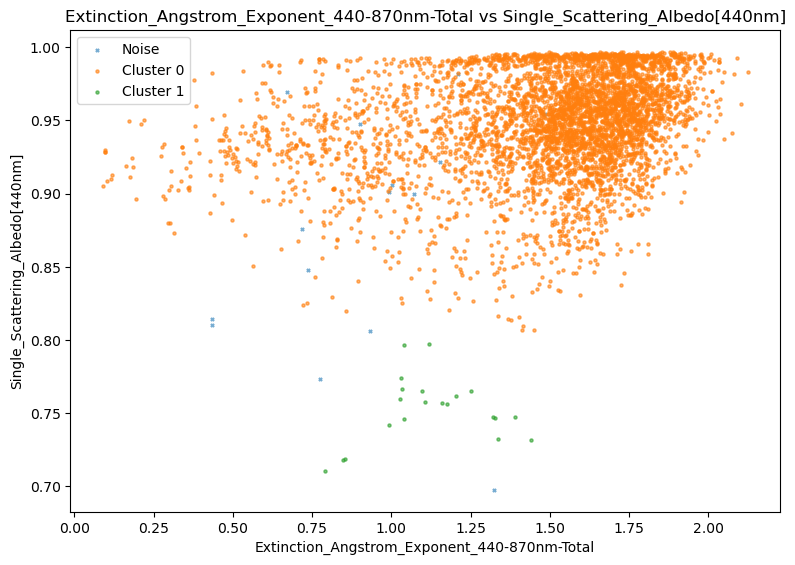

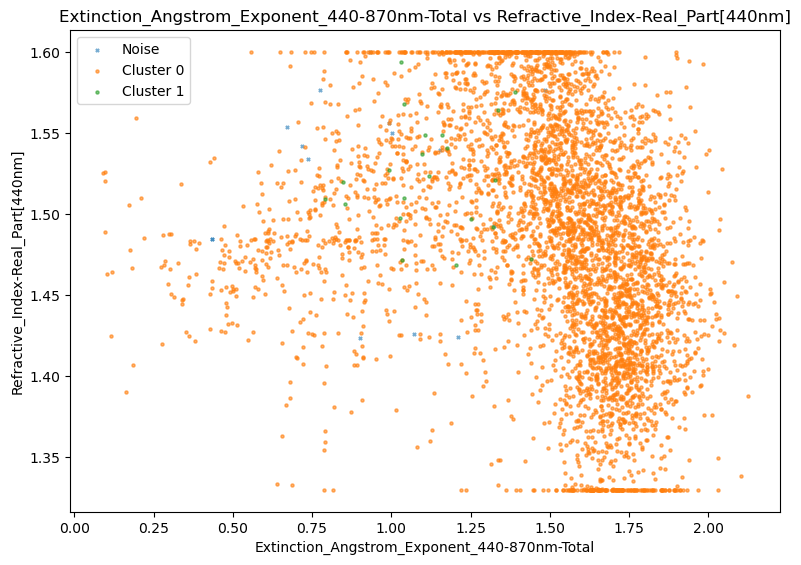

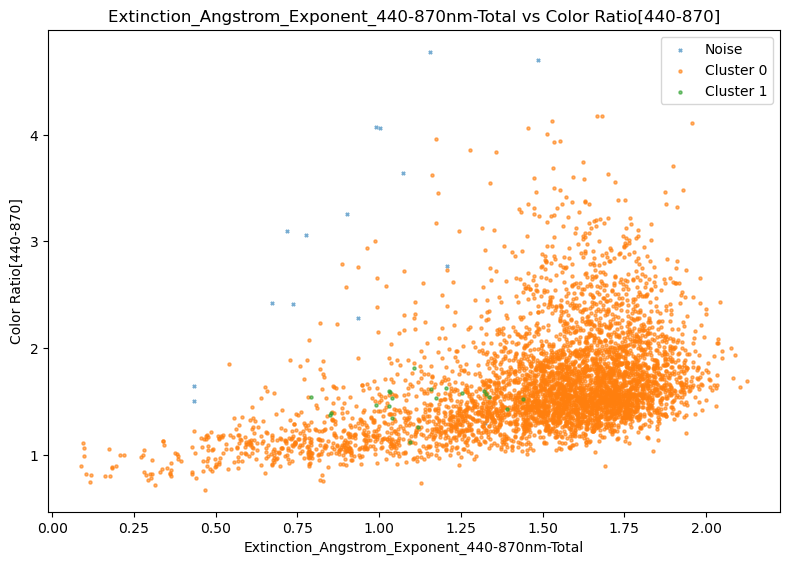

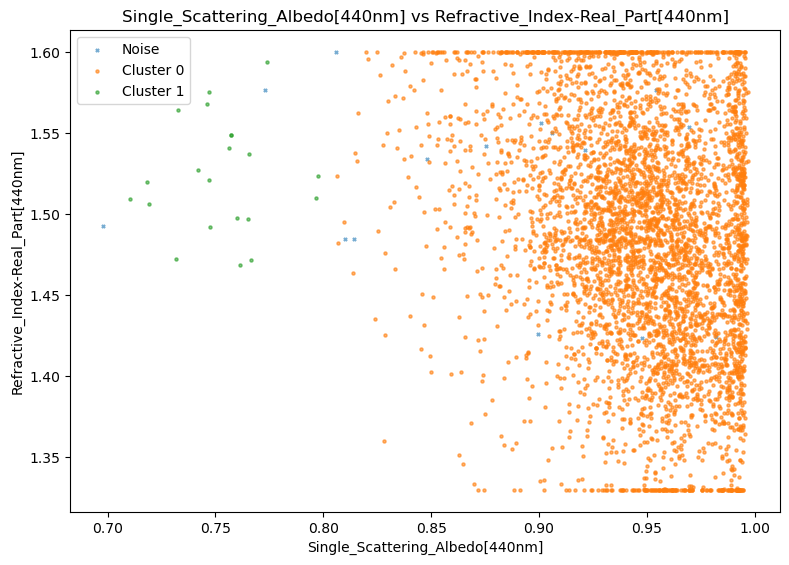

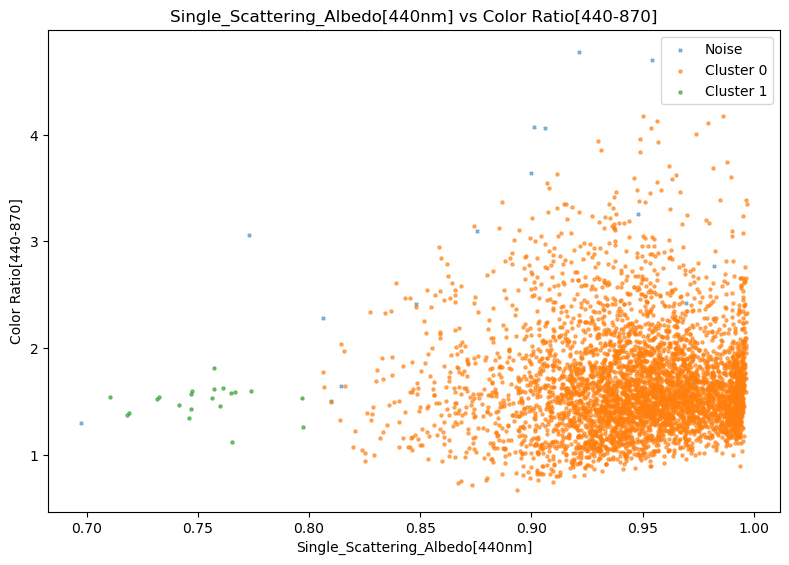

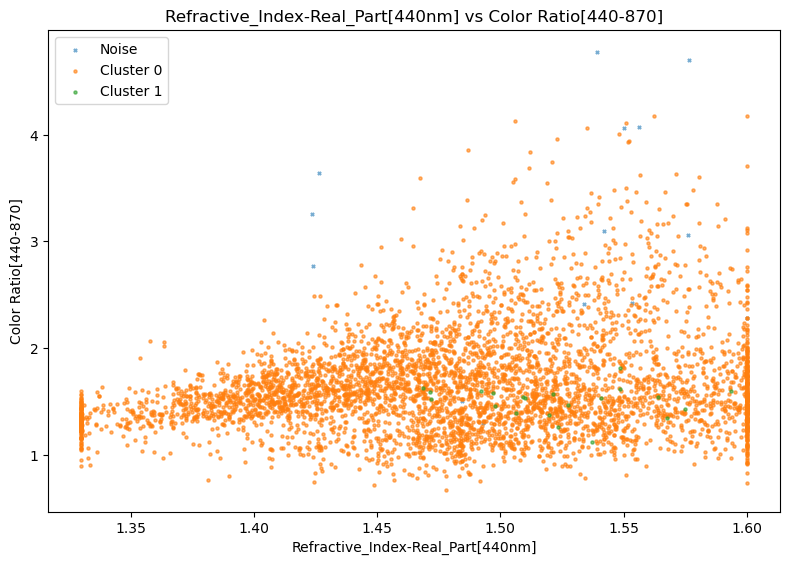

In [66]:
# scatter plot-ovi svih kombinacija parametara koji su korisceni za klasterizaciju

pairs = list(itertools.combinations(cols, 2))  # sve kombinacije po 2

for xcol, ycol in pairs:
    plt.figure(figsize=(8,6))
    for cluster in sorted(data_clean['cluster'].unique()):
        subset = data_clean[data_clean['cluster'] == cluster]
        if cluster == -1:
            label = "Noise"
            marker = "x"
        else:
            label = f"Cluster {cluster}"
            marker = "o"
        plt.scatter(subset[xcol], subset[ycol], label=label, alpha=0.6, s=5, marker=marker)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(f"{xcol} vs {ycol}", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # dodatni prostor za naslov

    filename = f"{xcol}_vs_{ycol}_dbscan.png".replace(" ", "_").replace("[", "").replace("]", "")
    filepath = os.path.join(save_folder, filename)
    plt.savefig(filepath, dpi=300)
    
    plt.show()

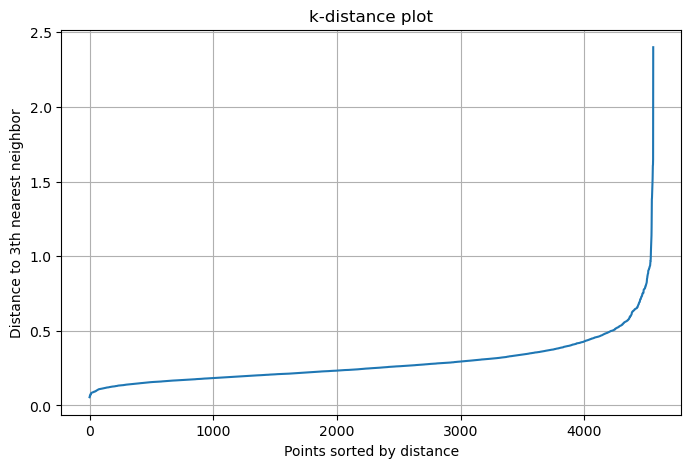

In [68]:
# min_samples koji koristim u DBSCAN
min_samples = 3

# skaliranje
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean[cols])

# racunanje rastojanja do k najblizih suseda (k = min_samples)
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)

# uzimam rastojanja do poslednjeg tj najdaljeg (k-tog) suseda
k_distances = np.sort(distances[:, -1])

# crtanje k-distance plot-a
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.ylabel(f"Distance to {min_samples}rd nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.title("k-distance plot")
plt.grid(True)

filename = f"k-distance_plot_dbscan.png"
filepath = os.path.join(save_folder, filename)
plt.savefig(filepath, dpi=300)

plt.show()


In [62]:
for eps in [0.8, 1.0, 1.2, 1.5]:
    for min_samples in [3, 5, 7]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"eps={eps}, min_samples={min_samples} → klastera: {n_clusters}")


eps=0.8, min_samples=3 → klastera: 4
eps=0.8, min_samples=5 → klastera: 3
eps=0.8, min_samples=7 → klastera: 3
eps=1.0, min_samples=3 → klastera: 2
eps=1.0, min_samples=5 → klastera: 2
eps=1.0, min_samples=7 → klastera: 2
eps=1.2, min_samples=3 → klastera: 1
eps=1.2, min_samples=5 → klastera: 1
eps=1.2, min_samples=7 → klastera: 1
eps=1.5, min_samples=3 → klastera: 1
eps=1.5, min_samples=5 → klastera: 1
eps=1.5, min_samples=7 → klastera: 1
